# Network Traffic Forecasting (using time series data)

In telco, accurately forecasting KPIs (e.g. network traffic, utilizations, user experience, etc.) for communication networks ( 2G/3G/4G/5G/wired) can help predict network failures, allocate resource, or save energy. 

In this notebook, we demonstrate a reference use case where we use the network traffic KPI(s) in the past to predict traffic KPI(s) in the future. We demostrate how to do **multivariate multistep forecasting** using Project Chronos.

For demonstration, we use the publicly available network traffic data repository maintained by the [WIDE project](http://mawi.wide.ad.jp/mawi/) and in particular, the network traffic traces aggregated every 2 hours (i.e. AverageRate in Mbps/Gbps and Total Bytes) in year 2018 and 2019 at the transit link of WIDE to the upstream ISP ([dataset link](http://mawi.wide.ad.jp/~agurim/dataset/)). 

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_predict_actual_values(date, y_pred, y_test, ylabel):
    """
    plot the predicted values and actual values (for the test data)
    """
    fig, axs = plt.subplots(figsize=(12,5))

    axs.plot(date, y_pred, color='red', label='predicted values')
    axs.plot(date, y_test, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test datetime')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

## Step 0: Prepare dataset

Chronos has provided built-in dataset APIs for easily download and preprocessed public dataset. You could find API guide [here](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html#built-in-dataset).

With below APIs, we first download network traffic data and then preprocess the downloaded dataset. The pre-processing mainly contains 2 parts:

1. Convert "StartTime" values from string to Pandas TimeStamp
2. Unify the measurement scale for "AvgRate" values - some uses Mbps, some uses Gbps

In [3]:
from bigdl.chronos.data.utils.public_dataset import PublicDataset

df = PublicDataset(name='network_traffic', 
                   path='~/.chronos/dataset', 
                   redownload=False).get_public_data().preprocess_network_traffic().df

In [4]:
df.head()

,StartTime,AvgRate,total
0,2018-01-01 00:00:00,306.23,275605455598
1,2018-01-01 02:00:00,285.03,256527692256
2,2018-01-01 04:00:00,247.39,222652190823
3,2018-01-01 06:00:00,211.55,190396029658
4,2018-01-01 08:00:00,234.82,211340468977


Visualize the target KPIs: "AvgRate" and "total"

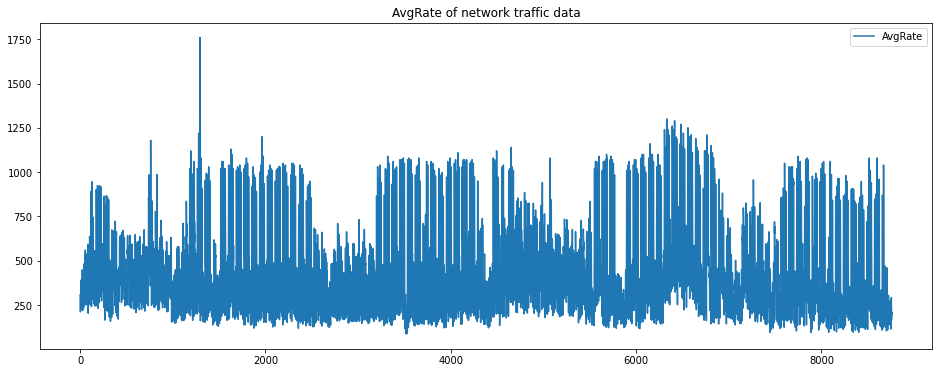

In [5]:
ax = df.plot(y='AvgRate', figsize=(16,6), title="AvgRate of network traffic data")

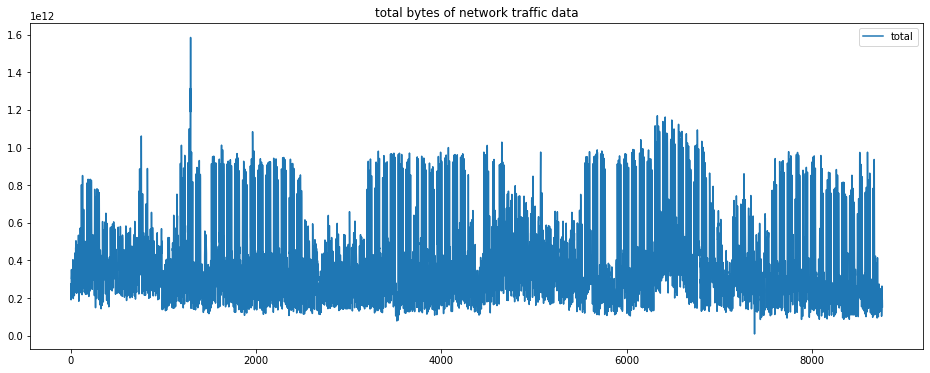

In [6]:
ax = df.plot(y='total', figsize=(16,6), title='total bytes of network traffic data')

## Step 1:  Data transformation and feature engineering using Chronos TSDataset

[TSDataset](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) is our abstract of time series dataset for data transformation and feature engineering. Here we use it to preprocess the data.

In [7]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

Initialize train, valid and test tsdataset from raw pandas dataframe.

In [8]:
tsdata_train, _, tsdata_test = TSDataset.from_pandas(df, dt_col="StartTime", target_col=["AvgRate", "total"], with_split=True, test_ratio=0.1)


Preprocess the datasets. Here we perform:

* gen_dt_feature: generate feature from datetime (e.g. month, day...)
* impute: fill the missing values
* scale: scale each feature to standard distribution.
* roll: sample the data with sliding window.

For forecasting task, we will look back 1 weeks' historical data (84 records with sample frequency of 2h) and predict the value of next 1 day (12 records).

We perform the same transformation processes on train and test set.

In [ ]:
look_back = 84
horizon = 12

standard_scaler = StandardScaler()

for tsdata in [tsdata_train, tsdata_test]:
    tsdata.gen_dt_feature(features=["HOUR", "WEEKDAY"], one_hot_features=["HOUR", "WEEKDAY"])\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=look_back, horizon=horizon)

Convert TSDataset to numpy.

In [ ]:
x_train, y_train = tsdata_train.to_numpy()
x_test, y_test = tsdata_test.to_numpy()

#x.shape = (num of sample, lookback, num of input feature)
#y.shape = (num of sample, horizon, num of output feature)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# Step 2: Time series forecasting using Chronos Forecaster

We demonstrate how to use chronos TCNForecaster for multi-variate and multi-step forecasting. For more details, you can refer to TCNForecaster document [here](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/forecasters.html#tcnforecaster).
First, we initialize a forecaster.
* `num_channels`: The filter numbers of the convolutional layers. It can be a list.
* `kernel_size`: Convolutional layer filter height.

In [ ]:
from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster
forecaster = TCNForecaster(past_seq_len = look_back,
                           future_seq_len = horizon,
                           input_feature_num = x_train.shape[-1],
                           output_feature_num = 2, # "AvgRate" and "total"
                           num_channels = [30] * 7,
                           repo_initialization = False,
                           kernel_size = 3, 
                           dropout = 0.1, 
                           lr = 0.001,
                           seed = 0)

You can use this method to print the parameter list.

In [ ]:
forecaster.data_config, forecaster.model_config

In [ ]:
%%time
forecaster.fit((x_train, y_train), epochs=20, batch_size=32)

After training is finished. You can use the forecaster to do prediction and evaluation.

In [ ]:
# make prediction
y_pred = forecaster.predict(x_test)

Since we have used standard scaler to scale the input data (including the target values), we need to inverse the scaling on the predicted values too. 

In [ ]:
y_pred_unscale = tsdata_test.unscale_numpy(y_pred)
y_test_unscale = tsdata_test.unscale_numpy(y_test)

Calculate mean square error and the symetric mean absolute percentage error.

In [ ]:
# evaluate with mse, smape
from bigdl.orca.automl.metrics import Evaluator
avgrate_mse = Evaluator.evaluate("mse", y_test_unscale[:, :, 0], y_pred_unscale[:, :, 0], multioutput='uniform_average')
avgrate_smape = Evaluator.evaluate("smape", y_test_unscale[:, :, 0], y_pred_unscale[:, :, 0], multioutput='uniform_average')
total_mse = Evaluator.evaluate("mse", y_test_unscale[:, :, 1], y_pred_unscale[:, :, 1], multioutput='uniform_average')
total_smape = Evaluator.evaluate("smape", y_test_unscale[:, :, 1], y_pred_unscale[:, :, 1], multioutput='uniform_average')
print(f"Evaluation result for AvgRate: mean squared error is {'%.2f' % avgrate_mse}, sMAPE is {'%.2f' % avgrate_smape}")
print(f"Evaluation result for total: mean squared error is {'%.2f' % total_mse}, sMAPE is {'%.2f' % total_smape}")

You may save & restore the forecaster.

In [ ]:
forecaster.save("network_traffic.fxt")
forecaster.load("network_traffic.fxt")

If you only want to save the pytorch model

In [ ]:
model = forecaster.get_model()

In [ ]:
import torch
torch.save(model, "tcn.pt")

## Visualization

Plot actual and prediction values for `AvgRate` KPI

In [ ]:
test_date=df[-y_pred_unscale.shape[0]:].index
# You can choose the number of painting steps by specifying the step by yourself.
step = 0 # the first step
target_name = "AvgRate"
target_index = 0
plot_predict_actual_values(date=test_date, y_pred=y_pred_unscale[:, step, target_index], y_test=y_test_unscale[:, step, target_index], ylabel=target_name)

Plot actual and prediction values for `total bytes` KPI

In [ ]:
target_name = "total"
target_index = 1
plot_predict_actual_values(date=test_date, y_pred=y_pred_unscale[:, step, target_index], y_test=y_test_unscale[:, step, target_index], ylabel=target_name)